In [19]:
import numpy as np
import matplotlib.pyplot as plt
from utils.Preprocess import Preprocess
from utils.CalculateDissimilarity import CalculateDissimilarity
from utils.GenerateSyntheticData import GenerateSyntheticData
from utils.GWOptimalTransfer import GWOptimalTransfer
from utils.PlotFigures import PlotFigures
import ot
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from utils.extract_paths import extract_paths
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
from run import run
from collections import OrderedDict
import itertools
from tqdm import tqdm
import time

In [20]:
gen_syn = False
non_al_folder_path = './qualia_rawdata/single_subject/non_alcohol/'
al_folder_path = './qualia_rawdata/single_subject/alcohol/'
plot_dim = 2
max_iter=500
comparing_pairs=('non_al', 'al')
qualia_color = {
    'empatic_pain': 'orange',
    'guilt': 'black',
    'fear': 'violet',
    'anger': 'red',
    'envy': 'purple',
    'sadness': 'blue',
    'surprise': 'gray',
    'joy': 'cyan',
    'amusement': 'brown',
    'romance': 'pink',
    'aesthetic_appreciation': 'yellow',
    'awe': 'green',
}

In [21]:
optimal_P = run(
    non_al_folder_path=non_al_folder_path,
    al_folder_path=al_folder_path,
    plot_dim=2,
    generate_syn=False,
    qualia_color=qualia_color,
    max_iter=500,
    comparing_pairs=('non_al', 'al')
  )
optimal_P.shape

(24, 24)

In [22]:
def plot_optimal_P_heatmap(optimal_P, tmp_optimal_P, min_error, tmp_error, emotions, min_emotions):
    fig = plt.figure(figsize=(10,4))
    #optimal_Pの可視化part2
    ax = fig.add_subplot(2,1,1)
    sns.heatmap(tmp_optimal_P, cmap='Reds', xticklabels=emotions, yticklabels=emotions, annot=True, fmt=".2f")
    ax.set_title(f'tmp_error: {tmp_error}')

    ax = fig.add_subplot(2,1,2)
    sns.heatmap(optimal_P, cmap='Reds', xticklabels=min_emotions, yticklabels=min_emotions, annot=True, fmt=".2f")
    ax.set_title(f'min_error: {min_error}')
    plt.show()

def calcurate_error(optimal_P):
    non_zero_positions = np.argwhere(optimal_P != 0)
    position_error = sum([np.abs(position[0]-position[1]) for position in non_zero_positions])
    return position_error
def swap_dict_items(d, key1, key2):
    # OrderedDictを使用して順序を保持
    d = OrderedDict(d)
    # key1とkey2の位置を取得
    keys = list(d.keys())
    index1, index2 = keys.index(key1), keys.index(key2)
    # key1とkey2の値を取得
    value1, value2 = d[key1], d[key2]
    # key1とkey2を削除
    del d[key1]
    del d[key2]
    # key1とkey2を新しい位置に挿入
    if index1 < index2:
        d.update({key2: value2})
        d.move_to_end(key2, last=False)
        d.update({key1: value1})
        d.move_to_end(key1, last=False)
    else:
        d.update({key1: value1})
        d.move_to_end(key1, last=False)
        d.update({key2: value2})
        d.move_to_end(key2, last=False)
    return d

100%|██████████| 66/66 [00:09<00:00,  6.88it/s]


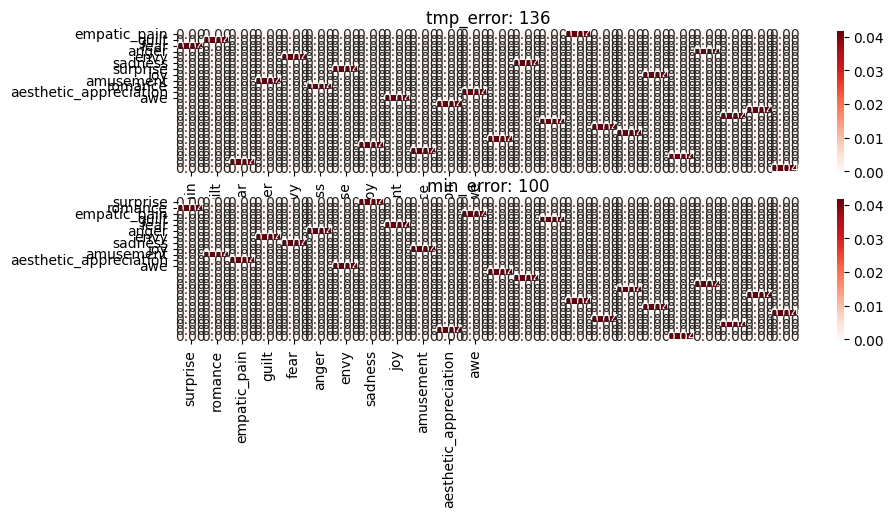

In [23]:
emotions = list(qualia_color.keys())
pairs = list(itertools.combinations(emotions, 2))
#ここから並び替え試行
def improve_by_swapping(pairs, max_iter=5):
    min_qualia_color = qualia_color
    min_error = 110
    for iter in range(max_iter):
        for pair in tqdm(pairs):
            tmp_qualia_color = dict(swap_dict_items(min_qualia_color, pair[0], pair[1]))
            tmp_optimal_P = run(
                non_al_folder_path=non_al_folder_path,
                al_folder_path=al_folder_path,
                plot_dim=2,
                generate_syn=False,
                qualia_color=tmp_qualia_color,
                max_iter=500,
                comparing_pairs=('non_al', 'al')
            )
            tmp_error = calcurate_error(optimal_P=tmp_optimal_P)
            if tmp_error < min_error:
                min_qualia_color = tmp_qualia_color
                min_emotions = list(min_qualia_color.keys())
                min_error = tmp_error
                min_optimal_P = tmp_optimal_P
    plot_optimal_P_heatmap(optimal_P=min_optimal_P, min_error=min_error, tmp_optimal_P=tmp_optimal_P, tmp_error=tmp_error, emotions=emotions, min_emotions =min_emotions)
    return min_qualia_color, min_optimal_P
min_qualia_color, min_optimal_P = improve_by_swapping(pairs)


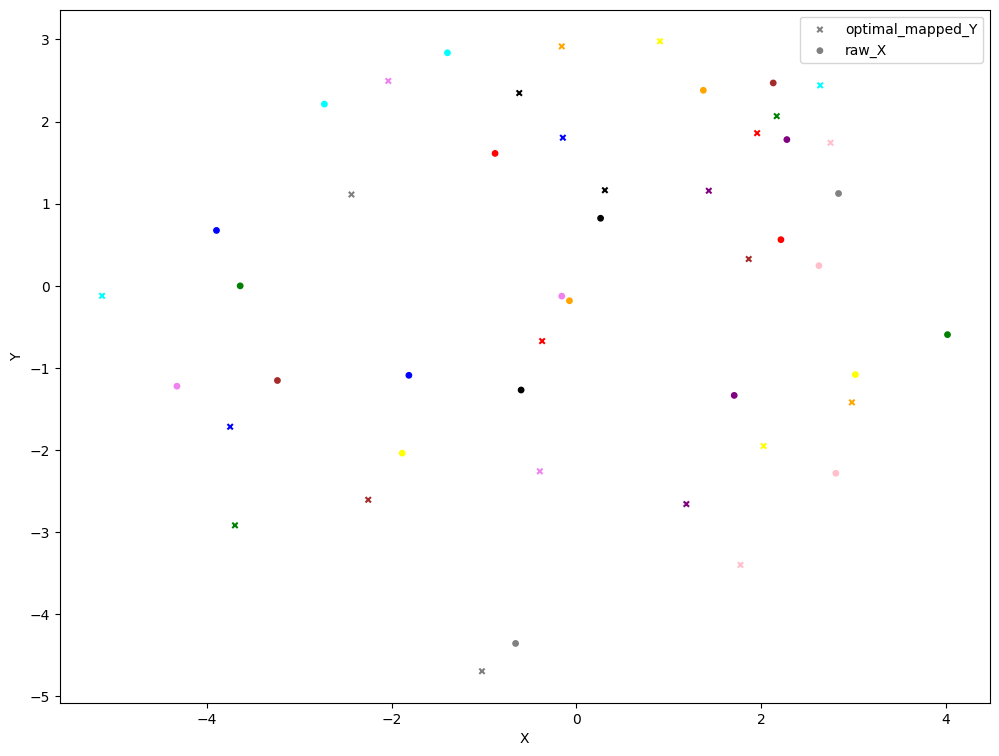

In [24]:
all_original_embeddings_list = list()
all_dissimilarity_matrices = list()
attributes = ['non_alcohol', 'alcohol']
qualia_color=min_qualia_color
first_qualia_paths, second_qualia_paths = extract_paths(
    non_al_folder_path=non_al_folder_path,
    al_folder_path=al_folder_path,
    comparing_pairs=comparing_pairs
)
for paths in [first_qualia_paths, second_qualia_paths]:
    preprocessed_dfs = list()
    for path in paths:
        #pathで指定された被験者の実験データを前処理して出力
        preprocess = Preprocess(path=path)
        sim_list, comparison_video_pairs = preprocess.extract_cols()
        preprocessed_df = preprocess.output_data(sim_list, comparison_video_pairs)
        #保存
        preprocessed_dfs.append(preprocessed_df)

    #類似度行列を計算し、それを基にノンアル、アルコールの場合の埋め込みベクトルをそれぞれ表示
    cal_dissim = CalculateDissimilarity(
        preprocessed_dfs=preprocessed_dfs,
        qualia_color=qualia_color)
    dissimilarity_matrices = cal_dissim.dissimilarity_matrices()
    all_dissimilarity_matrices.append(np.array(dissimilarity_matrices))
    original_embeddings_list = cal_dissim.original_embeddings(dissimilarity_matrices=dissimilarity_matrices, plot_dim=plot_dim)
    #save
    all_original_embeddings_list.append(original_embeddings_list)

#ノンアル/アルコール時の埋め込みベクトルを横並びに表示
# cal_dissim.plot_in_space(all_original_embeddings_list=all_original_embeddings_list , plot_dim=plot_dim, attributes=attributes)

#gw最適輸送の実行
X_embeddings = all_original_embeddings_list[0]
Y_embeddings = all_original_embeddings_list[1]
gwot = GWOptimalTransfer(
    X_embeddings=X_embeddings,
    Y_embeddings=Y_embeddings,
    qualia_color=qualia_color)
X_embeddings_combined, Y_embeddings_combined = gwot.reshape_embeddings()
optimal_P = gwot.gromov_wasserstein(
    X_embeddings_combined=X_embeddings_combined,
    Y_embeddings_combined=Y_embeddings_combined,
    max_iter=max_iter)

optimal_Q = gwot.calcurate_Q(
    X_embeddings_combined=X_embeddings_combined,
    Y_embeddings_combined=Y_embeddings_combined,
    optimal_P=optimal_P)
Y_optimal_mapped = gwot.calcurate_mapped_Y(
    optimal_Q=optimal_Q,
    optimal_P=optimal_P,
    Y_embeddings_combined=Y_embeddings_combined)
#元々のXの埋め込みと最適輸送による輸送後のYの埋め込みを同時にプロット
gwot.plot_optimal(
    X_embeddings_combined=X_embeddings_combined,
    Y_optimal_mapped=Y_optimal_mapped,
)

C:\Users\MEIP-users\AppData\Local\Temp\ipykernel_13604\1711797930.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


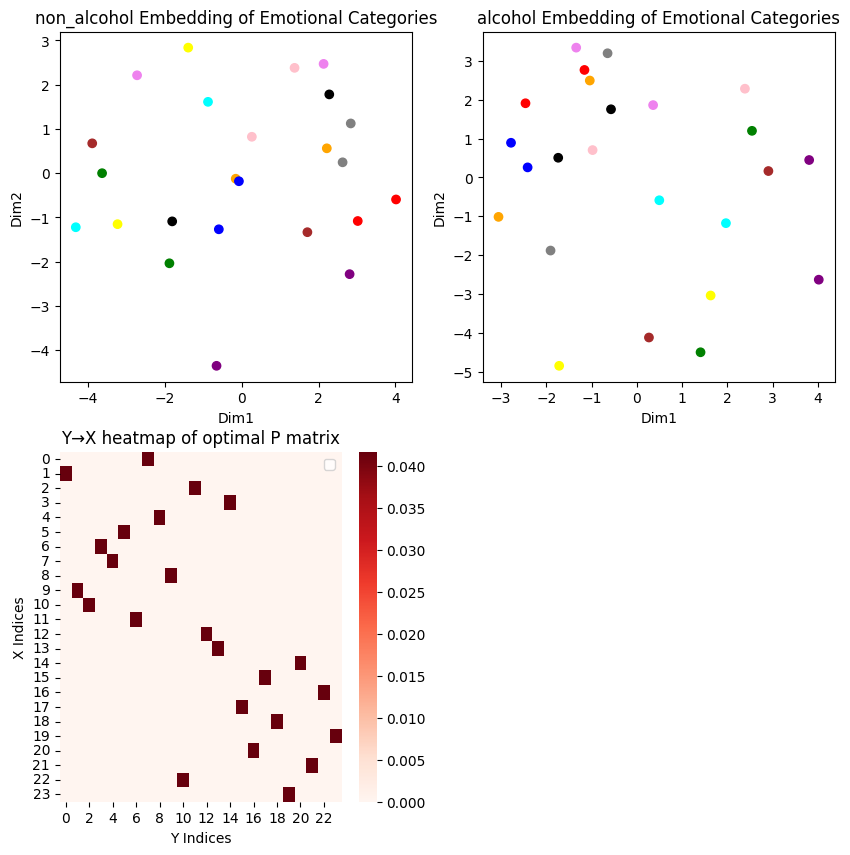

In [25]:
fig = plt.figure(figsize=(10,10))
plot_figures = PlotFigures(fig=fig, plot_dim=plot_dim, qualia_color=qualia_color)
fig1 = plot_figures.plot_original_embeddings(
    all_original_embeddings_list=all_original_embeddings_list,
    attributes=attributes,
    plot_dim=plot_dim)
fig2 = plot_figures.plot_optimal_P_heatmap(optimal_P=optimal_P)
plt.legend()
plt.show()